# WOA7015 ADVANCED MACHINE LEARNING
# Alternative Assesment

## Data exploring


In [3]:
from datasets import load_dataset

ds = load_dataset("flaviagiammarino/vqa-rad")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-eb8844602202be(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e5bc3d208bb4dee(…):   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

# Import libraries

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from torchvision import models, transforms
from PIL import Image
import pandas as pd

In [25]:
print(pd.__version__)

2.2.2


In [26]:
import torchvision
print(torchvision.__version__)

0.24.0+cu126


In [6]:
# 1. Creating dictionary of answers (Label Encoding)
# For baseline model our approach is classification problem
def create_answer_mapping(dataset):
    all_answers = [item['answer'].lower().strip() for item in dataset]
    unique_answers = sorted(list(set(all_answers)))
    ans_to_idx = {ans: i for i, ans in enumerate(unique_answers)}
    idx_to_ans = {i: ans for ans, i in ans_to_idx.items()}
    return ans_to_idx, idx_to_ans

In [7]:
# 2. Augmentations
# For medical images of lungs:
# - Random rotation to a few amount of angles
# Changing of brightness and contrast
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data preparation

In [8]:
class MedVQADataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, ans_to_idx, transform=None, max_len=32):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.ans_to_idx = ans_to_idx
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # Processing image
        image = item['image'].convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Processing question
        question = str(item['question'])
        inputs = self.tokenizer.encode_plus(
            question,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )

        # Processing answer
        answer_text = item['answer'].lower().strip()
        # If in test data we face new answer we set 0 or process separately
        answer_label = self.ans_to_idx.get(answer_text, 0)

        return {
            'image': image,
            'ids': inputs['input_ids'].flatten(),
            'mask': inputs['attention_mask'].flatten(),
            'label': torch.tensor(answer_label, dtype=torch.long)
        }

# First Method

# CNN-Based Multimodal

In [9]:
class BaselineMedVQA(nn.Module):
    def __init__(self, num_classes, text_model_name='bert-base-uncased'):
        super(BaselineMedVQA, self).__init__()

        # Visual Encoder: ResNet50
        resnet = models.resnet50(pretrained=True)
        self.visual_encoder = nn.Sequential(*(list(resnet.children())[:-1])) # Remove FC layer
        self.visual_projection = nn.Linear(2048, 768) # Projection to BERT dimensions

        # Text Encoder: BERT
        self.text_encoder = BertModel.from_pretrained(text_model_name)

        # Fusion & Classifier
        # We concatenate vectors (768 + 768 = 1536)
        self.classifier = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, image, ids, mask):
        # Extracting features from image
        visual_features = self.visual_encoder(image) # [batch, 2048, 1, 1]
        visual_features = visual_features.view(visual_features.size(0), -1)
        visual_emb = self.visual_projection(visual_features) # [batch, 768]

        # Extracting features from test (using CLS token)
        text_outputs = self.text_encoder(input_ids=ids, attention_mask=mask)
        text_emb = text_outputs.pooler_output # [batch, 768]

        # Fusion (Concatenation)
        combined = torch.cat((visual_emb, text_emb), dim=1)

        # Output logits
        logits = self.classifier(combined)
        return logits

In [10]:
split_ds = ds['train'].train_test_split(test_size=0.15, seed=42)

train_data = split_ds['train']
val_data = split_ds['test']
test_data = ds['test']

In [11]:
# initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ans_to_idx, idx_to_ans = create_answer_mapping(ds['train'])
num_classes = len(ans_to_idx)

# Dataloaders
train_set = MedVQADataset(train_data, tokenizer, ans_to_idx, transform=img_transforms)
val_set = MedVQADataset(val_data, tokenizer, ans_to_idx, transform=test_transforms)
test_set = MedVQADataset(test_data, tokenizer, ans_to_idx, transform=test_transforms)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
ans_to_idx['yes']

430

## Training

In [19]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import numpy as np
import torch

In [28]:
import sklearn as sk
print(sk.__version__)

1.6.1


In [20]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    pbar = tqdm(train_loader, desc='Training')
    for batch in pbar:
        # Moving data to GPU
        images = batch['image'].to(device)
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, ids, mask)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect predictions for metrics
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(train_loader)
    acc = accuracy_score(all_labels, all_preds)
    # We use weighted because of unbalanced classes
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, acc, f1

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            images = batch['image'].to(device)
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, ids, mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, acc, f1

In [23]:
from google.colab import drive
drive.mount('/content/drive')

base_dir= '/content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment'
os.makedirs(base_dir, exist_ok= True)

In [ ]:
# Optimizer
# Separating parameters
model = BaselineMedVQA(num_classes=num_classes).to(device)
backbone_params = list(model.visual_encoder.parameters()) + list(model.text_encoder.parameters())
head_params = list(model.visual_projection.parameters()) + list(model.classifier.parameters())

optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 2e-5, 'weight_decay':1e-2}, # Slower for pretrained layers
    {'params': head_params, 'lr': 1e-4, 'weight_decay':1e-2}      # Faster for new layers
])

optimizer = torch.optim.AdamW(
    model.parameters(), lr= 1e-5, weight_decay= 1e-2
)

In [ ]:
import numpy as np

def get_class_weights(dataset, ans_to_idx):
    # Calculate number of occurrences of each answer
    counts = np.zeros(len(ans_to_idx))

    for item in dataset:
        ans_text = item['answer'].lower().strip()
        if ans_text in ans_to_idx:
            idx = ans_to_idx[ans_text]
            counts[idx] += 1

    # To avoid dividing by 0
    counts = np.clip(counts, a_min=1, a_max=None)

    # calculating weights
    total_samples = len(dataset)
    num_classes = len(ans_to_idx)

    weights = total_samples / (num_classes * counts)

    return torch.tensor(weights, dtype=torch.float)

criterion = nn.CrossEntropyLoss()

In [24]:
# Settings
num_epochs = 100
best_val_f1 = 0.0
patience = 10
patience_counter = 0

# History for graphs in report
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Validation
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

    # Logging
    print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")

    # Saving history for graphs
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    # Early Stopping and saving best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0  # Reset counter
        torch.save(model.state_dict(), f'{base_dir}/best_baseline_model.pth')
        print(f"!!! New Best Model Saved (Val F1: {val_f1:.4f}) !!!")
    else:
        patience_counter += 1
        print(f"No improvement in F1. Patience: {patience_counter}/{patience}")

    # Check early stopping condition
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered! Training stopped at epoch {epoch+1}")
        break


Epoch 1/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.13it/s]


Train Loss: 3.6787 | Train F1: 0.2042 | Train Acc: 0.2907
Val Loss: 3.5075 | Val F1: 0.2075 | Val Acc: 0.3011
!!! New Best Model Saved (Val F1: 0.2075) !!!

Epoch 2/100


Validating: 100%|██████████| 17/17 [00:04<00:00,  4.19it/s]


Train Loss: 3.2799 | Train F1: 0.2411 | Train Acc: 0.3228
Val Loss: 3.4709 | Val F1: 0.2436 | Val Acc: 0.3011
!!! New Best Model Saved (Val F1: 0.2436) !!!

Epoch 3/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.07it/s]


Train Loss: 3.2201 | Train F1: 0.2781 | Train Acc: 0.3320
Val Loss: 3.4592 | Val F1: 0.2780 | Val Acc: 0.3086
!!! New Best Model Saved (Val F1: 0.2780) !!!

Epoch 4/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Train Loss: 3.0992 | Train F1: 0.3354 | Train Acc: 0.3766
Val Loss: 3.4543 | Val F1: 0.3159 | Val Acc: 0.3420
!!! New Best Model Saved (Val F1: 0.3159) !!!

Epoch 5/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.07it/s]


Train Loss: 3.0404 | Train F1: 0.4041 | Train Acc: 0.4409
Val Loss: 3.4688 | Val F1: 0.3181 | Val Acc: 0.3457
!!! New Best Model Saved (Val F1: 0.3181) !!!

Epoch 6/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.14it/s]


Train Loss: 2.9445 | Train F1: 0.4385 | Train Acc: 0.4659
Val Loss: 3.4752 | Val F1: 0.3554 | Val Acc: 0.3717
!!! New Best Model Saved (Val F1: 0.3554) !!!

Epoch 7/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.25it/s]


Train Loss: 2.8484 | Train F1: 0.4517 | Train Acc: 0.4790
Val Loss: 3.5279 | Val F1: 0.3136 | Val Acc: 0.3532
No improvement in F1. Patience: 1/10

Epoch 8/100


Validating: 100%|██████████| 17/17 [00:04<00:00,  4.02it/s]


Train Loss: 2.8316 | Train F1: 0.4579 | Train Acc: 0.4888
Val Loss: 3.5716 | Val F1: 0.3484 | Val Acc: 0.3717
No improvement in F1. Patience: 2/10

Epoch 9/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.10it/s]


Train Loss: 2.7764 | Train F1: 0.4729 | Train Acc: 0.5020
Val Loss: 3.5514 | Val F1: 0.3445 | Val Acc: 0.3643
No improvement in F1. Patience: 3/10

Epoch 10/100


Validating: 100%|██████████| 17/17 [00:04<00:00,  4.05it/s]


Train Loss: 2.7522 | Train F1: 0.4811 | Train Acc: 0.5151
Val Loss: 3.5900 | Val F1: 0.3527 | Val Acc: 0.3792
No improvement in F1. Patience: 4/10

Epoch 11/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.17it/s]


Train Loss: 2.6718 | Train F1: 0.4861 | Train Acc: 0.5197
Val Loss: 3.6132 | Val F1: 0.3553 | Val Acc: 0.3829
No improvement in F1. Patience: 5/10

Epoch 12/100


Validating: 100%|██████████| 17/17 [00:04<00:00,  4.03it/s]


Train Loss: 2.6445 | Train F1: 0.4947 | Train Acc: 0.5276
Val Loss: 3.5924 | Val F1: 0.3627 | Val Acc: 0.3866
!!! New Best Model Saved (Val F1: 0.3627) !!!

Epoch 13/100


Validating: 100%|██████████| 17/17 [00:04<00:00,  4.07it/s]


Train Loss: 2.6209 | Train F1: 0.4985 | Train Acc: 0.5335
Val Loss: 3.6132 | Val F1: 0.3586 | Val Acc: 0.3866
No improvement in F1. Patience: 1/10

Epoch 14/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]


Train Loss: 2.5854 | Train F1: 0.5082 | Train Acc: 0.5420
Val Loss: 3.6628 | Val F1: 0.3666 | Val Acc: 0.3941
!!! New Best Model Saved (Val F1: 0.3666) !!!

Epoch 15/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.16it/s]


Train Loss: 2.5418 | Train F1: 0.5028 | Train Acc: 0.5348
Val Loss: 3.6508 | Val F1: 0.3659 | Val Acc: 0.3941
No improvement in F1. Patience: 1/10

Epoch 16/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.90it/s]


Train Loss: 2.4848 | Train F1: 0.5125 | Train Acc: 0.5492
Val Loss: 3.6887 | Val F1: 0.3632 | Val Acc: 0.3941
No improvement in F1. Patience: 2/10

Epoch 17/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.13it/s]


Train Loss: 2.4759 | Train F1: 0.5093 | Train Acc: 0.5466
Val Loss: 3.7152 | Val F1: 0.3694 | Val Acc: 0.4052
!!! New Best Model Saved (Val F1: 0.3694) !!!

Epoch 18/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.92it/s]


Train Loss: 2.4339 | Train F1: 0.5178 | Train Acc: 0.5584
Val Loss: 3.7085 | Val F1: 0.3757 | Val Acc: 0.4015
!!! New Best Model Saved (Val F1: 0.3757) !!!

Epoch 19/100


Validating: 100%|██████████| 17/17 [00:04<00:00,  4.15it/s]


Train Loss: 2.4243 | Train F1: 0.5143 | Train Acc: 0.5558
Val Loss: 3.7636 | Val F1: 0.3771 | Val Acc: 0.4052
!!! New Best Model Saved (Val F1: 0.3771) !!!

Epoch 20/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.30it/s]


Train Loss: 2.3631 | Train F1: 0.5243 | Train Acc: 0.5617
Val Loss: 3.7457 | Val F1: 0.3699 | Val Acc: 0.4015
No improvement in F1. Patience: 1/10

Epoch 21/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.18it/s]


Train Loss: 2.3443 | Train F1: 0.5336 | Train Acc: 0.5715
Val Loss: 3.7564 | Val F1: 0.3730 | Val Acc: 0.4052
No improvement in F1. Patience: 2/10

Epoch 22/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s]


Train Loss: 2.2993 | Train F1: 0.5322 | Train Acc: 0.5774
Val Loss: 3.8501 | Val F1: 0.3703 | Val Acc: 0.3941
No improvement in F1. Patience: 3/10

Epoch 23/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.16it/s]


Train Loss: 2.2855 | Train F1: 0.5344 | Train Acc: 0.5741
Val Loss: 3.8230 | Val F1: 0.3725 | Val Acc: 0.4015
No improvement in F1. Patience: 4/10

Epoch 24/100


Validating: 100%|██████████| 17/17 [00:04<00:00,  4.16it/s]


Train Loss: 2.2208 | Train F1: 0.5386 | Train Acc: 0.5814
Val Loss: 3.8386 | Val F1: 0.3705 | Val Acc: 0.3978
No improvement in F1. Patience: 5/10

Epoch 25/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.23it/s]


Train Loss: 2.2146 | Train F1: 0.5439 | Train Acc: 0.5873
Val Loss: 3.8365 | Val F1: 0.3655 | Val Acc: 0.3941
No improvement in F1. Patience: 6/10

Epoch 26/100


Validating: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]


Train Loss: 2.1767 | Train F1: 0.5470 | Train Acc: 0.5951
Val Loss: 3.9063 | Val F1: 0.3715 | Val Acc: 0.4052
No improvement in F1. Patience: 7/10

Epoch 27/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.26it/s]


Train Loss: 2.1637 | Train F1: 0.5449 | Train Acc: 0.5899
Val Loss: 3.9195 | Val F1: 0.3477 | Val Acc: 0.3829
No improvement in F1. Patience: 8/10

Epoch 28/100


Validating: 100%|██████████| 17/17 [00:04<00:00,  4.04it/s]


Train Loss: 2.1183 | Train F1: 0.5452 | Train Acc: 0.5899
Val Loss: 3.8891 | Val F1: 0.3584 | Val Acc: 0.3978
No improvement in F1. Patience: 9/10

Epoch 29/100


Validating: 100%|██████████| 17/17 [00:03<00:00,  5.24it/s]

Train Loss: 2.0818 | Train F1: 0.5461 | Train Acc: 0.5912
Val Loss: 3.9712 | Val F1: 0.3682 | Val Acc: 0.3978
No improvement in F1. Patience: 10/10

Early stopping triggered! Training stopped at epoch 29


## Results for method 1

In [ ]:
model = BaselineMedVQA(num_classes=num_classes)

model_path = 'best_baseline_model_method1_all_q.pth'

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

model.to(device)
model.eval()
print(f"Successfully loaded model weights from {model_path}")

Successfully loaded model weights from best_baseline_model_method1_all_q.pth


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
import torch
import numpy as np

def evaluate_test(model, test_loader, device):
    model.eval()  # Moving to eval mode

    all_preds = []
    all_labels = []

    print("Starting evaluation on test set...")

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label'].to(device)

            # Predict
            outputs = model(images, ids, mask)
            _, preds = torch.max(outputs, 1)

            # Collect for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print("-" * 30)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1-Score (Macro): {f1:.4f}")
    print("-" * 30)

    # print("Classification Report:")
    # print(classification_report(all_labels, all_preds))

    return acc, f1

test_acc, test_f1 = evaluate_test(model, test_loader, device)

Starting evaluation on test set...
------------------------------
Test Accuracy: 0.3814
Test F1-Score (Macro): 0.0458
------------------------------


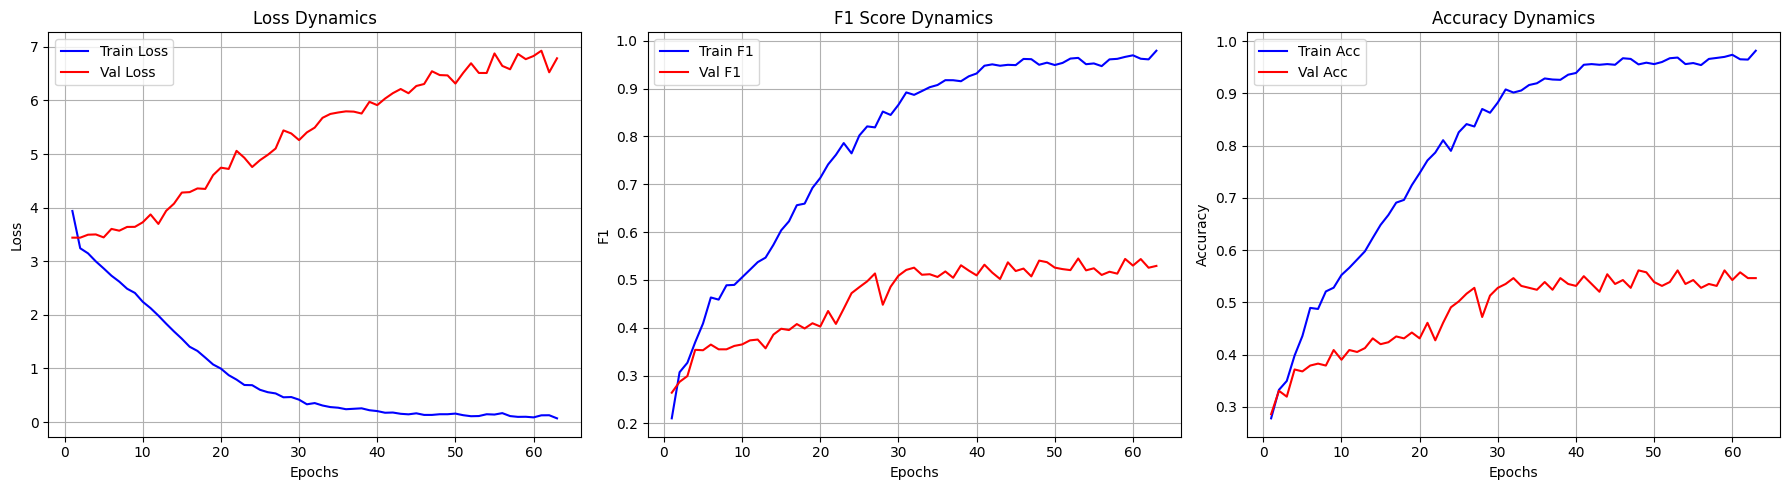

In [31]:
import matplotlib.pyplot as plt

def plot_comprehensive_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 5))

    # 1. Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Loss Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. F1 Score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_f1'], 'b-', label='Train F1')
    plt.plot(epochs, history['val_f1'], 'r-', label='Val F1')
    plt.title('F1 Score Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.grid(True)

    # 3. Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    plt.title('Accuracy Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_comprehensive_history(history)

## Method 1 for closed-ended questions

Let's try to train our model on closed ended questions

In [ ]:
# Filter for Yes/No answers
def filter_yes_no(example):
    ans = example['answer'].lower().strip()
    return ans in ['yes', 'no']

# Applying
ds_yes_no = ds.filter(filter_yes_no)

print(f"Original size: {len(ds['train']) + len(ds['test'])}")
print(f"Yes/No size: {len(ds_yes_no['train']) + len(ds_yes_no['test'])}")

Original size: 2244
Yes/No size: 1191


In [ ]:
split_ds = ds_yes_no['train'].train_test_split(test_size=0.15, seed=42)

train_data = split_ds['train']
val_data = split_ds['test']
test_data = ds_yes_no['test']

print(f'train {len(train_data)}')
print(f'val {len(val_data)}')
print(f'test {len(test_data)}')

train 799
val 141
test 251


In [ ]:
# initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ans_to_idx, idx_to_ans = create_answer_mapping(ds['train'])
num_classes = len(ans_to_idx)

In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# Collecting all labels from train
train_labels = []
for i in range(len(train_data)):
    ans = train_data[i]['answer'].lower().strip()
    train_labels.append(ans_to_idx.get(ans, 0))

train_labels = np.array(train_labels)

# Count all occurences of every class
class_sample_count = np.array([len(np.where(train_labels == t)[0]) for t in range(num_classes)])

# Weight of class= 1/n of occurences
weight = 1. / class_sample_count
samples_weight = torch.from_numpy(weight[train_labels]).double()

# Making sampler
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

/tmp/ipython-input-3619140388.py:17: RuntimeWarning: divide by zero encountered in divide
  weight = 1. / class_sample_count


In [ ]:
img_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Dataloaders
train_set = MedVQADataset(train_data, tokenizer, ans_to_idx, transform=img_transforms)
val_set = MedVQADataset(val_data, tokenizer, ans_to_idx, transform=test_transforms)
test_set = MedVQADataset(test_data, tokenizer, ans_to_idx, transform=test_transforms)

batch_size = 64
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    sampler=sampler, # Adding sampler
    shuffle=False
)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [ ]:
# Model
model = BaselineMedVQA(num_classes=num_classes).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Optimizer
# Separating parameters
backbone_params = list(model.visual_encoder.parameters()) + list(model.text_encoder.parameters())
head_params = list(model.visual_projection.parameters()) + list(model.classifier.parameters())


optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 2e-5, 'weight_decay':1e-2, 'label_smoothing':0.1}, # Slower for pretrained layers
    {'params': head_params, 'lr': 1e-4, 'weight_decay':1e-2, 'label_smoothing':0.1}      # Faster for new layers
])

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

num_epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs//5, eta_min=1e-6)

In [ ]:
for param in model.visual_encoder.parameters():
    param.requires_grad = False

for param in model.visual_encoder[7].parameters(): # layer4
    param.requires_grad = True

for param in model.text_encoder.parameters():
    param.requires_grad = False

for name, param in model.text_encoder.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name or "pooler" in name:
        param.requires_grad = True

In [ ]:
import numpy as np

criterion = nn.CrossEntropyLoss()

In [ ]:
# Settings
best_val_f1 = 1e4
patience = 10
patience_counter = 0

# History for graphs in report
history = {
    'train_loss': [], 'val_loss': [],
    'train_f1': [], 'val_f1': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Validation
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)
    scheduler.step()

    # Logging
    print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")

    # Saving history for graphs
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_f1)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: Learning Rate = {current_lr:.6f}")

    # Early Stopping and saving best model
    if val_f1 < best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0  # Reset counter
        save_dir= '/content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment'
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), f'{save_dir}/method1_yes_no epoch: {epoch}.pth')
        print(f"!!! New Best Model Saved (Val Loss: {val_loss:.4f}) !!!")
    else:
        patience_counter += 1
        print(f"No improvement in val_loss. Patience: {patience_counter}/{patience}")

    # # Check early stopping condition
    # if patience_counter >= patience:
    #     print(f"\nEarly stopping triggered! Training stopped at epoch {epoch+1}")
    #     break


Epoch 1/100


Training:   0%|          | 0/13 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model = BaselineMedVQA(num_classes=num_classes)

model_path = '/content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment/method1_yes_no epoch: 46.pth'

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

model.to(device)
model.eval()
print(f"Successfully loaded model weights from {model_path}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Successfully loaded model weights from /content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment/method1_yes_no epoch: 46.pth


In [ ]:
test_acc, test_f1 = evaluate_test(model, test_loader, device)

Starting evaluation on test set...
------------------------------
Test Accuracy: 0.6853
Test F1-Score (Macro): 0.6801
------------------------------


KeyError: 'train_acc'

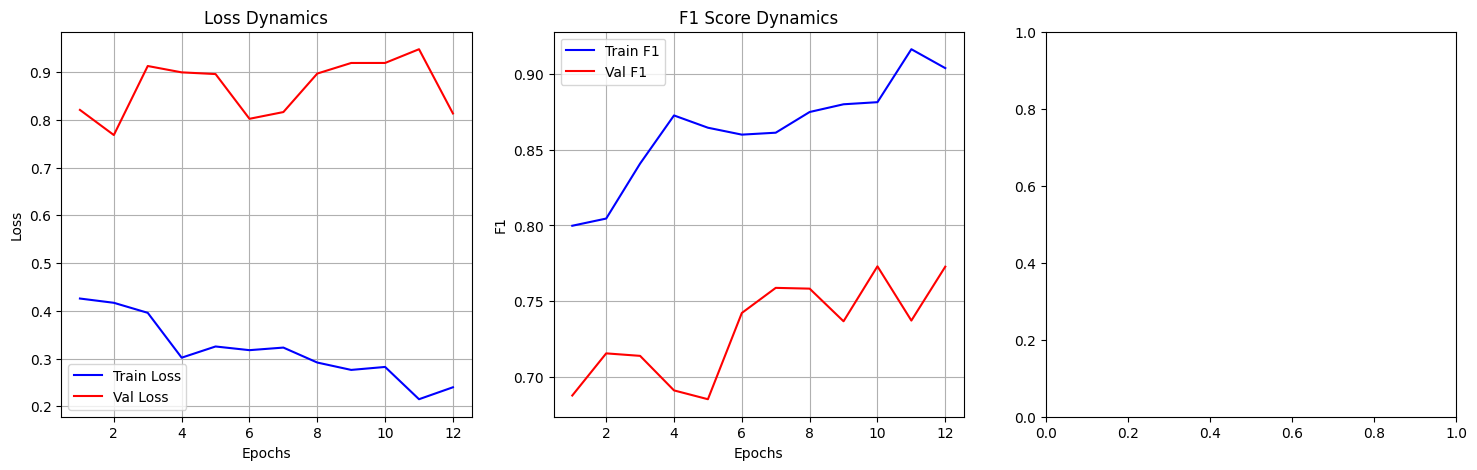

In [ ]:
def plot_comprehensive_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 5))

    # 1. Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Loss Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. F1 Score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_f1'], 'b-', label='Train F1')
    plt.plot(epochs, history['val_f1'], 'r-', label='Val F1')
    plt.title('F1 Score Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.grid(True)

    # 3. Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    plt.title('Accuracy Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_comprehensive_history(history)

# Method 2

# Med-Flamingo is not suitable because its too big




In [ ]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration

model_name = "Salesforce/blip2-flan-t5-xl"

processor = Blip2Processor.from_pretrained(model_name)

model_blip = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    device_map="auto",
    load_in_8bit=True
    # ,
    # torch_dtype=torch.float16
)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
class Blip2MedDataset(Dataset):
    def __init__(self, hf_dataset, processor, max_len=32):
        self.dataset = hf_dataset
        self.processor = processor
        self.max_len = max_len

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'].convert('RGB')
        question = item['question']
        question = f"Question: {item['question']} Short answer:"
        answer = item['answer'].lower().strip()

        if self.dataset.split == 'train':
          image = img_transforms(image)

        # 1. Обработка картинки и вопроса
        inputs = self.processor(
            images=image,
            text=question,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )

        encoding = {k: v.squeeze(0) for k, v in inputs.items()}


        # 2. Обработка ответа (Labels)
        # Обязательно добавляем padding и truncation здесь тоже!
        labels_inputs = self.processor.tokenizer(
            answer,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=10 # Для yes/no 10 токенов более чем достаточно
        )

        labels = labels_inputs.input_ids.squeeze()

        # 3. Маскируем паддинг значением -100
        # Чтобы модель не училась предсказывать технические токены [PAD]
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        encoding['labels'] = labels
        return encoding

In [ ]:
img_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

In [ ]:
split_ds = ds['train'].train_test_split(test_size=0.15, seed=42)

train_data = split_ds['train']
val_data = split_ds['test']
test_data = ds['test']

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
    # 1. Картинки всегда одного размера (224x224), их просто стекаем
    pixel_values = torch.stack([item['pixel_values'] for item in batch])

    # 2. Вопросы (input_ids) могут различаться, если max_length не отработал
    input_ids = [item['input_ids'] for item in batch]
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=processor.tokenizer.pad_token_id)

    # 3. Маска внимания для вопросов
    attention_mask = [item['attention_mask'] for item in batch]
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    # 4. Ответы (labels) — паддинг значением -100
    labels = [item['labels'] for item in batch]
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'labels': labels_padded
    }


train_ds = Blip2MedDataset(train_data, processor)
val_ds   = Blip2MedDataset(val_data, processor)
test_ds  = Blip2MedDataset(test_data, processor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

# 1. Подготовка модели к квантованному обучению
# model_blip.gradient_checkpointing_enable()
model_blip_prepare = prepare_model_for_kbit_training(model_blip)

# 2. Конфигурация LoRA
# Мы цепляемся за Q-Former или за языковую модель (Self-Attention слои)
# Конфигурация для BLIP-2 OPT
# Альтернативный вариант (таргетинг на Q-Former)
config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q", "v", 'query', 'value'],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)


model = get_peft_model(model_blip_prepare, config)
# model.enable_input_require_grads()
# Выведем количество обучаемых параметров
model.print_trainable_parameters()

NameError: name 'model_blip' is not defined

In [ ]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scaler = GradScaler()

def train_epoch(model, dataloader, optimizer, device): # Убрали scaler
    model.train()
    total_loss = 0

    pbar = tqdm(dataloader, desc="Training")
    for batch in pbar:
        optimizer.zero_grad()

        pixel_values = batch['pixel_values'].to(device, dtype=torch.float16)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Используем autocast, но без GradScaler
        # with torch.amp.autocast('cuda'):
        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return total_loss / len(dataloader)

NameError: name 'model' is not defined

In [ ]:
def validate_and_generate(model, dataloader, processor, device):
    model.eval()
    total_loss = 0
    examples = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Training")
        for i, batch in enumerate(pbar):
            pixel_values = batch['pixel_values'].to(device, dtype=torch.float16)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # 1. Считаем лосс
            outputs = model(pixel_values=pixel_values, input_ids=input_ids, labels=labels)
            total_loss += outputs.loss.item()

            # 2. Генерируем ответ для первого батча, чтобы почитать глазами
            if i == 0:
                generated_ids = model.generate(pixel_values=pixel_values,
                                               input_ids=input_ids,

                                               max_length=10)
                decoded_preds = processor.batch_decode(generated_ids, skip_special_tokens=True)
                # Чистим метки от -100 для декодирования
                clean_labels = labels.clone()
                clean_labels[clean_labels == -100] = processor.tokenizer.pad_token_id
                decoded_labels = processor.batch_decode(clean_labels, skip_special_tokens=True)

                for p, l in zip(decoded_preds, decoded_labels):
                    examples.append(f"Pred: {p.strip()} | True: {l.strip()}")

    return total_loss / len(dataloader), examples

In [ ]:
model.config.use_cache = False

In [ ]:
import os
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 100

history = {
    'train_loss': [], 'val_loss': []
}

best_val_loss = float('inf')
save_dir= '/content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment'
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    avg_train_loss = train_epoch(model, train_loader, optimizer, device)
    avg_val_loss, val_examples = validate_and_generate(model, val_loader, processor, device)

    print(f"Avg Train Loss: {avg_train_loss:.4f}")
    print(f"Avg Val Loss: {avg_val_loss:.4f}")
    print("Samples from Validation:")
    for ex in val_examples[:3]:
        print(ex)

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        save_path = f"{save_dir}/blip2_lora_medical_epoch_{epoch}__val_loss_{avg_val_loss}"
        best_val_loss = avg_val_loss
        model.save_pretrained(save_path)
        processor.save_pretrained(save_path)
        print(f"!!! Best model saved to {save_path} (Loss: {best_val_loss:.4f})")


Epoch 1/100


Training:   0%|          | 0/48 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Training: 100%|█

Avg Train Loss: 1.7886
Avg Val Loss: 1.6890
Samples from Validation:
Pred: left | True: right hemisphere
Pred: yes | True: yes
Pred: a solitary apical | True: ring enhancing lesion
!!! Best model saved to /content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment/blip2_lora_medical_epoch_0__val_loss_1.6890256934695773 (Loss: 1.6890)

Epoch 2/100


Training: 100%|██████████| 9/9 [01:11<00:00,  7.93s/it]


Avg Train Loss: 1.6733
Avg Val Loss: 1.6152
Samples from Validation:
Pred: left | True: right hemisphere
Pred: yes | True: yes
Pred: apical apical | True: ring enhancing lesion
!!! Best model saved to /content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment/blip2_lora_medical_epoch_1__val_loss_1.615193850464291 (Loss: 1.6152)

Epoch 3/100


Training: 100%|██████████| 9/9 [01:39<00:00, 11.07s/it]


Avg Train Loss: 1.5727
Avg Val Loss: 1.5556
Samples from Validation:
Pred: left hemisphere | True: right hemisphere
Pred: no | True: yes
Pred: atypical | True: ring enhancing lesion
!!! Best model saved to /content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment/blip2_lora_medical_epoch_2__val_loss_1.5556045638190374 (Loss: 1.5556)

Epoch 4/100


Training: 100%|██████████| 9/9 [01:14<00:00,  8.28s/it]


Avg Train Loss: 1.4524
Avg Val Loss: 1.5076
Samples from Validation:
Pred: right hemisphere | True: right hemisphere
Pred: no | True: yes
Pred: atypical ad | True: ring enhancing lesion
!!! Best model saved to /content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment/blip2_lora_medical_epoch_3__val_loss_1.5075617167684767 (Loss: 1.5076)

Epoch 5/100


Training:  52%|█████▏    | 25/48 [05:53<04:11, 10.93s/it, loss=1.18]

## Results


In [ ]:
!gdown 1mI8dre-YO6gGApmQCGpV54KDFt8MWigU --folder

Retrieving folder contents
Processing file 1ylGyVf6GlRiyFpcrruf9PEdS9bo24qn7 adapter_config.json
Processing file 1OeU-sP8nZEwMa929K0cqJ4Umx40BYpro adapter_model.safetensors
Processing file 1xkAamA1JGV35pt4hU4uaLI3nJlV9Zii_ added_tokens.json
Processing file 1NMwzvXqmZxUcOFDSL2RyFkDiEOHnyB5b preprocessor_config.json
Processing file 12glk4LnyGsns_i4QzGxCMzWryTWcrgVD processor_config.json
Processing file 1__XrEBK67Z8zH0FbotJzGWPm_np7CsrF README.md
Processing file 181M1bV6l0IobPP1CW0Ndfy7ENxmwuMKX special_tokens_map.json
Processing file 1u-_oZjM024WbH87ACDFyIF1512aDV-0Z spiece.model
Processing file 10cuynuATpagZFY0b6ED_jpWcTX5PmmTZ tokenizer_config.json
Processing file 12y72n9STCHhZOdxCTDte4R90uZhwyzNk tokenizer.json
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1ylGyVf6GlRiyFpcrruf9PEdS9bo24qn7
To: /content/blip2_lora_medical_epoch_3__val_loss_1.5075617167684767/adapter_config.jso

In [ ]:
# # Удаляем старые версии, чтобы избежать конфликтов
# !pip uninstall -y bitsandbytes accelerate transformers

# # Устанавливаем заново
# !pip install -U bitsandbytes
# !pip install -U git+https://github.com/huggingface/transformers.git
# !pip install -U git+https://github.com/huggingface/accelerate.git
# !pip install -U peft

In [ ]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from peft import PeftModel

model_name = "Salesforce/blip2-flan-t5-xl"
# Укажите актуальный путь к папке с адаптером
adapter_path = "/content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment/blip2_lora_medical_epoch_3__val_loss_1.5075617167684767"

processor = Blip2Processor.from_pretrained(model_name)


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

TypeError: Blip2ForConditionalGeneration.__init__() got an unexpected keyword argument 'load_in_8bit'

In [ ]:

# 1. Сначала грузим базовую модель
base_model = Blip2ForConditionalGeneration.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto",
    torch_dtype=torch.float16
)

# 2. Накладываем ваши веса
model = PeftModel.from_pretrained(base_model, adapter_path)
model.eval()

print("Модель готова к работе!")

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

def evaluate_model(model, dataloader, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            pixel_values = batch['pixel_values'].to(device, dtype=torch.float16)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'] # Оставляем на CPU для декодирования

            # Генерация ответа
            generated_ids = model.generate(
                pixel_values=pixel_values,
                input_ids=input_ids,
                max_length=15,
                repetition_penalty=1.5 # Чтобы избежать "a a a"
            )

            # Декодируем предсказания
            preds = processor.batch_decode(generated_ids, skip_special_tokens=True)
            preds = [p.strip().lower() for p in preds]

            # Декодируем правильные ответы
            labels[labels == -100] = processor.tokenizer.pad_token_id
            targets = processor.batch_decode(labels, skip_special_tokens=True)
            targets = [t.strip().lower() for t in targets]

            all_preds.extend(preds)
            all_labels.extend(targets)

    return all_preds, all_labels

# Запускаем оценку на test_loader
preds, targets = evaluate_model(model, test_loader, device)

In [ ]:
# Пример расчета точности
acc = accuracy_score(targets, preds)
print(f"Overall Accuracy: {acc:.4f}")

# Вывод нескольких примеров для анализа
for i in range(5):
    print(f"Target: {targets[i]} | Pred: {preds[i]}")

# paligemma

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = "vikhyatk/moondream2"
revision = "2024-08-26"

tokenizer = AutoTokenizer.from_pretrained(model_id, revision=revision)

# Загружаем модель с принудительным использованием классической реализации attention
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    revision=revision,
    torch_dtype=torch.float16,
    device_map="auto",
    attn_implementation="eager" # Это решает проблему KeyError: 'type'
)

print("✅ Moondream2 успешно загружена!")

PhiForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


KeyError: 'type'

In [ ]:
split_ds = ds['train'].train_test_split(test_size=0.15, seed=42)

train_data = split_ds['train']
val_data = split_ds['test']
test_data = ds['test']

In [ ]:
class MoondreamDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, tokenizer):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image'].convert('RGB')

        # Moondream имеет свой кодировщик картинок
        pixel_values = model.encode_image(image)

        # Формат: Вопрос + Ответ
        full_text = f"Question: {item['question']}\nAnswer: {item['answer']}<|endoftext|>"

        tokens = self.tokenizer(
            full_text,
            truncation=True,
            padding="max_length",
            max_length=64,
            return_tensors="pt"
        )

        return {
            "pixel_values": pixel_values.squeeze(0),
            "input_ids": tokens["input_ids"].squeeze(0),
            "labels": tokens["input_ids"].squeeze(0) # В CAUSAL_LM labels = input_ids
        }

train_loader = torch.utils.data.DataLoader(
    MoondreamDataset(train_data, tokenizer),
    batch_size=8, # Можно ставить больше, она легкая
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    MoondreamDataset(val_data, tokenizer),
    batch_size=8, # Можно ставить больше, она легкая
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    MoondreamDataset(test_data, tokenizer),
    batch_size=8, # Можно ставить больше, она легкая
    shuffle=False
)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.train()
for epoch in range(3):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Moondream forward pass
        loss = model(
            pixel_values=batch["pixel_values"].to("cuda", dtype=torch.float16),
            input_ids=batch["input_ids"].to("cuda"),
            labels=batch["labels"].to("cuda")
        ).loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch} Loss: {total_loss/len(train_loader)}")